In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-06-04 11:44:16.285096: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  0


In [1]:
#load data
import pandas as pd

labels = pd.read_csv('../labels.csv', header=0, sep=';')

labels_no_useless = labels[~labels.apply(lambda x: all(int(rule) == 1 for rule in x[1:]), axis=1)]

rule_8 = labels_no_useless[labels_no_useless['Rule8'] == 1]

other_rules = labels_no_useless[labels_no_useless['Rule8'] == 0].sample(n=rule_8.shape[0]*2, random_state=42)

balanced_labels = pd.concat([rule_8, other_rules])

balanced_labels= balanced_labels[["Image_name", "Rule8"]]

balanced_labels.info()

balanced_labels.to_csv('../model_arthur/balanced_labels.csv', sep=';', index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186 entries, 148 to 934
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image_name  186 non-null    object
 1   Rule8       186 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.4+ KB


In [1]:
import os
from PIL import Image
import pandas as pd
from pandas import read_csv
import numpy as np

img_folder = "../Yoio_Park_Proof"
target_size = (512, 512)
label_data = read_csv("../model_arthur/balanced_labels.csv", sep=";")

# Function to load and resize an image
def load_image(img_path, target_size):
    with Image.open(img_path) as img:
        img = img.resize(target_size)
        img = img.convert('RGB')  # Ensure image is in RGB format
        return np.array(img)

# Read images and their corresponding labels
image_data = []
image_labels = []

for idx, row in label_data.iterrows():
    img_name = row['Image_name']
    img_path = os.path.join(img_folder, img_name)
    
    if os.path.exists(img_path):
        img_array = load_image(img_path, target_size)
        image_data.append(img_array)
        image_labels.append(row[1])  # Assuming labels are in columns after 'Image'
        print(f"Loaded image {img_name} with label {row[1]}", end='\r')
    else:
        print(f"Warning: Image {img_name} not found in folder {img_folder}")



In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_data, image_labels, test_size=0.2, random_state=42)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [36]:
print(y_test.shape)

(38,)


In [3]:


import pickle

with open('../model_arthur/test_img.pickle', 'wb') as f:
    pickle.dump((X_test, y_test), f)

In [3]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

#generate augmented images
image_num = 2000 - len(X_train)
augmented_images = []
augmented_labels = []
target_size = (512, 512, 3)
print("Generating ", image_num, " augmented images...")

generated_count = 0

for batch in datagen.flow(X_train, y_train, batch_size=1):
  augmented_images.append(batch[0])
  augmented_labels.append(batch[1])
  generated_count += batch[0].shape[0]
  print("Generated ", generated_count, " augmented images", end='\r')
  if generated_count >= image_num:
    print("Generating done, generated", image_num, " augmented images")
    break

2024-06-08 09:00:34.728175: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Generating  1852  augmented images...
Generating done, generated 1852  augmented images


In [6]:
# Konvertieren der Listen in numpy Arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

In [24]:
augmented_images.shape, augmented_labels.shape, X_train.shape, y_train.shape

((1852, 512, 512, 3), (1852,), (148, 512, 512, 3), (148,))

In [23]:
augmented_images = augmented_images.reshape(augmented_images.shape[0], 512, 512, 3)
augmented_labels = augmented_labels.reshape(augmented_labels.shape[0])

In [25]:


# Kombinieren der augmentierten Bilder und Labels mit den ursprünglichen Trainingsdaten
X_train_augmented = np.concatenate((X_train, augmented_images), axis=0)
y_train_augmented = np.concatenate((y_train, augmented_labels), axis=0)

print(len(X_train_augmented))

2000


In [15]:
import pickle


with open('../model_arthur/data_useable_2.pickle', 'wb') as f:
    pickle.dump((X_train_augmented, y_train_augmented), f)



In [1]:
import pickle
import numpy as np

# Load the augmented images and labels from the file
with open('../model_arthur/data_useable_2.pickle', 'rb') as f:
    augmented_images, augmented_labels = pickle.load(f)


augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

augmented_images.shape

(2000, 512, 512, 3)

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout

# Define the CNN model
# architecture: conv layer maxpooling batchnorm -> conv layer maxpooling batchnorm -> conv layer maxpooling batchnorm -> fully connected layer -> output layer
# output layer is a single neuron with sigmoid activation function
# output should be a probability between 0 and 1

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 3)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='sigmoid')
])

2024-06-08 13:26:09.190017: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/axxtur/Documents/Uni/Data-Science-Case-Studies-SoSe24/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [3]:
from keras.utils import to_categorical

from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

#model.summary()


In [4]:
from keras.utils import to_categorical


history = model.fit(
  augmented_images,
  to_categorical(augmented_labels),
  validation_split=0.2,
  epochs=10,
  batch_size=32
  )



Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 568s 11s/step - accuracy: 0.6056 - loss: 25.9514 - val_accuracy: 0.6450 - val_loss: 707.3926
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1354s 27s/step - accuracy: 0.6228 - loss: 11.1217 - val_accuracy: 0.6250 - val_loss: 1360.7942
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 648s 13s/step - accuracy: 0.6289 - loss: 0.7896 - val_accuracy: 0.6425 - val_loss: 235.6204
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 752s 15s/step - accuracy: 0.6546 - loss: 0.6376 - val_accuracy: 0.6275 - val_loss: 41.0632
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 785s 15s/step - accuracy: 0.6605 - loss: 0.6496 - val_accuracy: 0.6425 - val_loss: 4.0615
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 564s 11s/step - accuracy: 0.6681 - loss: 0.6131 - val_accuracy: 0.6425 - val_loss: 0.9264
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 532s 10s/step - accuracy: 0.6553 - loss: 0.6212 - val_accuracy: 0.6450 - val_loss: 0.6878
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 736s 15s/step - accuracy: 0.6468 - loss: 0.6290 - val_a

In [5]:
model.save('../model_arthur/own_model_1.h5')

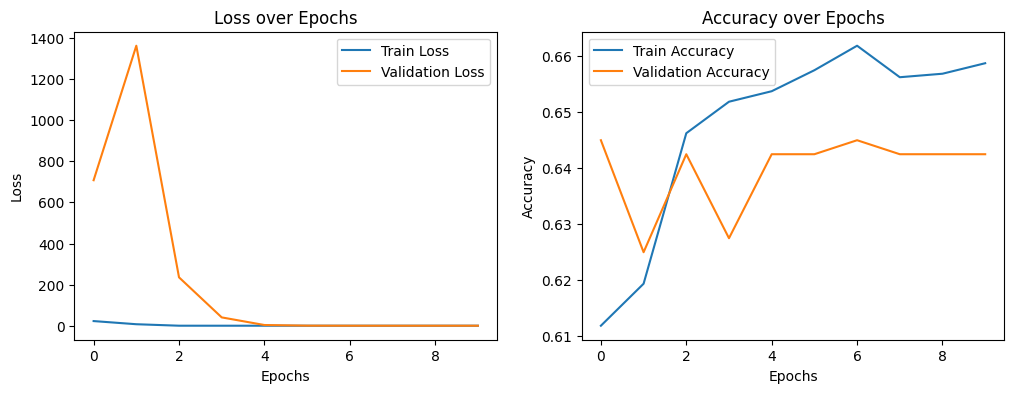

In [6]:
# Optionally, plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()